In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import find_peaks

In [2]:
data = pd.read_csv('TrozoG.txt', delimiter='\t', header=None, skiprows = range(3), decimal = ",", index_col = False)

In [3]:
print(len(data))
data.drop(columns=[3], inplace=True)
data.columns = ['LP','VD','TiempoGABA']
data = data.apply(pd.to_numeric)
# data['Time'] = data.index*0.1
data['Time'] = data.index

print(data.head())

# Sample interval = 0,100000
# Number of channels = 3
# Number of samples per channel = 16384000

16384000
         LP        VD  TiempoGABA  Time
0 -0.006104  0.064697    0.120239     0
1 -0.004272  0.075989    0.126343     1
2 -0.003357  0.087280    0.125427     2
3 -0.005188  0.092468    0.123596     3
4 -0.007324  0.093384    0.118713     4


In [4]:
data.dropna(axis=0, how='any',inplace=True)
data.isnull().sum()

LP            0
VD            0
TiempoGABA    0
Time          0
dtype: int64

In [5]:
data.describe()

,LP,VD,TiempoGABA,Time
count,1.638400e+07,1.638400e+07,1.638400e+07,1.638400e+07
mean,1.782227e-11,4.330900e-02,1.361662e-01,8.192000e+06
std,8.109792e-02,3.337760e-02,2.849763e-01,4.729654e+06
min,-6.420900e-01,-3.088380e-01,-5.462600e-02,0.000000e+00
25%,-2.624500e-02,3.326400e-02,1.141360e-01,4.096000e+06
50%,0.000000e+00,4.303000e-02,1.199340e-01,8.192000e+06
75%,2.441400e-02,5.310100e-02,1.260380e-01,1.228800e+07
max,9.265140e-01,5.520630e-01,5.220642e+00,1.638400e+07


In [6]:
percentil_lp =    np.quantile(data.LP,0.995)
percentil_vd =    np.quantile(data.VD,0.995)
percentil_gaba =    np.quantile(data.TiempoGABA,0.95)

print('Percentil LP: %f\nPercentil VD: %f\nPercentil GABA: %f' % (percentil_lp, percentil_vd, percentil_gaba))


Percentil LP: 0.432129
Percentil VD: 0.282593
Percentil GABA: 0.135803


In [7]:
spikes_lp = find_peaks(data['LP'])[0]
spikes_vd = find_peaks(data['VD'])[0]

lp_sp_data = pd.DataFrame(data = {'Time':spikes_lp,'ValueLP':data['LP'][spikes_lp],'IsSpikeLP' : 1})
lp_sp_data = lp_sp_data[lp_sp_data['ValueLP'] >= percentil_lp]

vd_sp_data = pd.DataFrame(data = {'Time':spikes_vd,'ValueVD':data['VD'][spikes_vd],'IsSpikeVD' : 1})
vd_sp_data = vd_sp_data[vd_sp_data['ValueVD'] >= percentil_vd]


In [8]:
data = pd.merge(data, lp_sp_data, on = 'Time', how='left')
data = pd.merge(data, vd_sp_data, on = 'Time', how='left')

In [9]:
# Medicion de Errores
data_test = data[['Time','IsSpikeLP','IsSpikeVD']]

window_sizes = np.arange(10,500,10)

errorsLP = []
errorsVD = []

for br in window_sizes:
    break_size = br
    breaks = np.arange(0,len(data_test),break_size)
    data_test.loc[:,'breaks'] = np.repeat(breaks,break_size)[0:len(data_test)]
    data_test_err = data_test.groupby('breaks')[['IsSpikeLP','IsSpikeVD']].agg('sum').reset_index()
    data_test_err['ErrorsLP'] = data_test_err['IsSpikeLP'] > 1
    data_test_err['ErrorsVD'] = data_test_err['IsSpikeVD'] > 1
    errorsLP.append(sum(data_test_err['ErrorsLP'])/len(data_test_err)*100)
    errorsVD.append(sum(data_test_err['ErrorsVD'])/len(data_test_err)*100)

errors_df = pd.DataFrame({'SizeWindow':window_sizes, 'ErrorPerLP':errorsLP, 'ErrorPerVD':errorsVD})

C:\Users\marlo\AppData\Local\Temp\ipykernel_27584\185616401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:,'breaks'] = np.repeat(breaks,break_size)[0:len(data_test)]


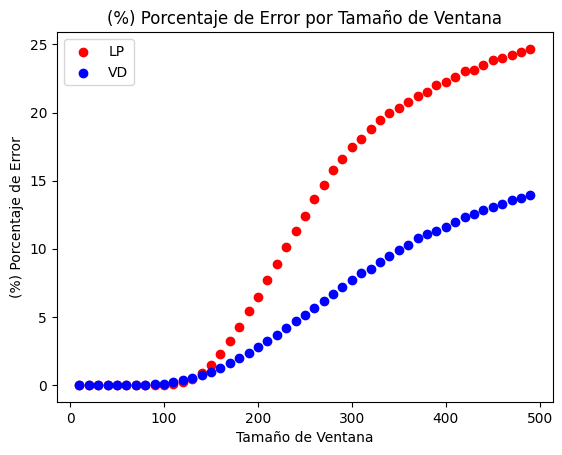

In [10]:
plt.scatter(errors_df.SizeWindow, errors_df.ErrorPerLP, color = 'red', label = 'LP')
plt.scatter(errors_df.SizeWindow, errors_df.ErrorPerVD, color = 'blue', label = 'VD')
plt.title('(%) Porcentaje de Error por Tamaño de Ventana')
plt.xlabel('Tamaño de Ventana')
plt.ylabel('(%) Porcentaje de Error')
plt.legend()

In [11]:
break_size = 100

breaks = np.arange(0,len(data),break_size)
data['breaks'] = np.repeat(breaks,break_size)[0:len(data)]

Text(0, 0.5, 'LP')

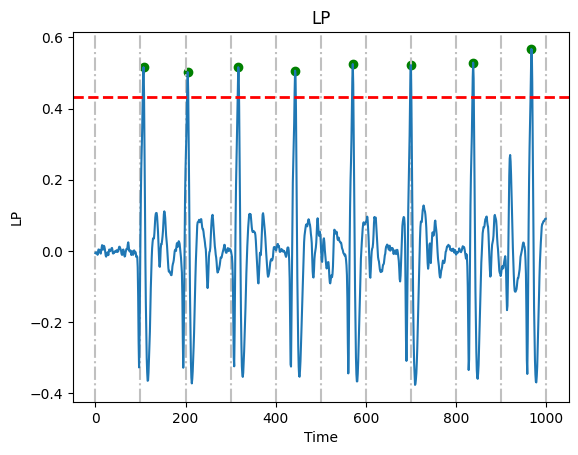

In [12]:
data_init = 0
data_end = 1000


data_samp = data.iloc[data_init:data_end]

for i in breaks[breaks<=data_end]:
    plt.axvline(x=i, color = 'silver', linestyle = '-.')

plt.plot(data_samp.Time, data_samp.LP)
plt.scatter(data_samp.Time[data_samp['IsSpikeLP'] == 1], data_samp.ValueLP[data_samp['IsSpikeLP'] == 1], color = 'green')
plt.axhline(y = percentil_lp, color='r', linestyle='--', linewidth=2)
plt.title('LP')
plt.xlabel('Time')
plt.ylabel('LP')



Text(0, 0.5, 'VD')

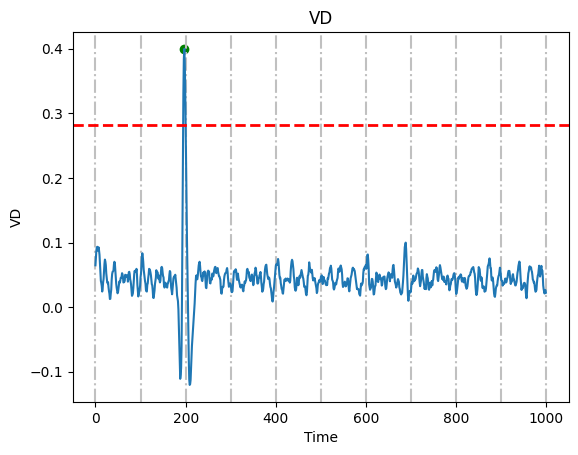

In [13]:
data_init = 0
data_end = 1000

data_samp = data.iloc[data_init:data_end]

for i in breaks[breaks<=data_end]:
    plt.axvline(x=i, color = 'silver', linestyle = '-.')

plt.plot(data_samp.Time, data_samp.VD)
plt.scatter(data_samp.Time[data_samp['IsSpikeVD'] == 1], data_samp.ValueVD[data_samp['IsSpikeVD'] == 1], color = 'green')
plt.axhline(y = percentil_vd, color='r', linestyle='--', linewidth=2)
plt.title('VD')
plt.xlabel('Time')
plt.ylabel('VD')
